In [1]:
import torch
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)

Function: $$f(x) = w^T \sqrt{(Ax)^2 + 1}$$

Gradient Calculations:

Expanding the summation form: $$f(x) = \sum_{i = 1}^{m} w_i \sqrt{(A_ix)^2 + 1} $$
where $A_ix$ is scalar as $A_i$ is $1,n$ and $x$ is $n,1$.
The inner function in this equation is $$g(x) = (Ax)$$ and the outer function is $$g(y) = w \sqrt{g^2+1}$$


Compute gradient of inner function.
$$g(x) = Ax$$
Because A is a constant matrix, its gradient is just
$$∇g(x) = A$$

Compute gradient of outer function:
$$h(g) = w^T \sqrt{g^2 + 1}$$
Summation notation:
$$h(g) = \sum_{i = 1}^{m} w_i \sqrt{g_i^2 + 1}$$
Differentiate each term with respect to g.
$$\frac{d}{dg_i}\sqrt{g_i^2 + 1} = \frac{g_i}{\sqrt{g_i^2 + 1}}$$
Add w_i back in:
$$\frac{d}{dg_i}h(g) = w_i \frac{g_i}{\sqrt{g_i^2 + 1}}$$
Now we can substitude $A_ix$ in for $g_i$ and define D as:
$$D =
\begin{bmatrix}
\frac{A_1 x}{\sqrt{(A_1 x)^2 + 1}} & 0 & \cdots & 0 \\
0 & \frac{A_2 x}{\sqrt{(A_2 x)^2 + 1}} & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & \frac{A_m x}{\sqrt{(A_m x)^2 + 1}}
\end{bmatrix}$$
Now we can define the gradient of the outer function as
$$\nabla h(g) = Dw$$

Finally we need to multiply the inner gradient and outer gradient to get a final answer. The dimension of the inner gradient is $m,n$ and the dimension of the outer gradient is $m,1$ so we must transpose A to get the correct calculation. $$\nabla f(x) = A^TDw$$



In [2]:
m = 5
n = 10

A = torch.randn(m, n)  # random m×n matrix
w = torch.randn(m,1)
# x is dim n, 1

# function
def f(x):
  return w.T @ torch.sqrt((A@x)**2+1)
  #w is n,1
  # s

#gradient
def grad_f(x):
  g = A @ x  #shape (m,1)

  g = g.squeeze()  #  from (m,1) to (m,)

  D = torch.diag(g / torch.sqrt(g ** 2 + 1))  # shape: (m,m)

  Dw = D @ w  # shape: (m,)

  grad = A.T @ Dw  # shape: (n,)

  return grad


#gradient using AD
def grad_f_AD(x):
  dim = x.shape[0]
  assert x.shape == (dim, 1) # ensuring input is valid in context
  #track the input
  x.requires_grad = True
  y = f(x)
  dy = torch.autograd.grad(outputs=y, inputs=x,grad_outputs=torch.ones_like(y), create_graph=True)[0]

  #detach variables to release memeory
  x = x.detach()
  y = y.detach()
  dy = dy.detach()

  return dy






In [ ]:
dim = n
x = torch.randn(dim,1)
v = torch.randn_like(x)
v = v / torch.norm(v)

max_iters = 32
h = torch.zeros(max_iters)
err0 = torch.zeros(max_iters) # error from zero order T.P.
err1 = torch.zeros(max_iters) # error from first order T.P.

for i in range(max_iters):
  h[i] = 2**(-i) # iterate h down

  #regular way
  # fv = f(x + h[i]*v)
  # T0 = f(x)
  # T1 = T0 + h[i] * (grad_f(x)).T @ v

  #using AD
  fv = f(x+h[i]*v).detach()
  T0 = f(x).detach()
  T1 = T0 + h[i] * (grad_f_AD(x)).T @ v



  err0[i] = torch.norm(fv - T0)
  err1[i] = torch.norm(fv - T1)
  print('h: %.3e, \t err0: %.3e, \t err1: %.3e' % (h[i], err0[i], err1[i]))

(array([1.e-18, 1.e-16, 1.e-14, 1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04,
        1.e-02, 1.e+00, 1.e+02, 1.e+04]),
 [Text(0, 1e-18, '$\\mathdefault{10^{-18}}$'),
  Text(0, 1e-16, '$\\mathdefault{10^{-16}}$'),
  Text(0, 1e-14, '$\\mathdefault{10^{-14}}$'),
  Text(0, 1e-12, '$\\mathdefault{10^{-12}}$'),
  Text(0, 1e-10, '$\\mathdefault{10^{-10}}$'),
  Text(0, 1e-08, '$\\mathdefault{10^{-8}}$'),
  Text(0, 1e-06, '$\\mathdefault{10^{-6}}$'),
  Text(0, 0.0001, '$\\mathdefault{10^{-4}}$'),
  Text(0, 0.01, '$\\mathdefault{10^{-2}}$'),
  Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
  Text(0, 100.0, '$\\mathdefault{10^{2}}$'),
  Text(0, 10000.0, '$\\mathdefault{10^{4}}$')])

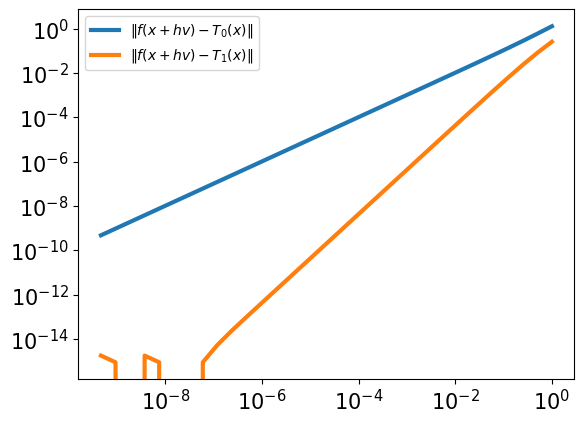

In [4]:
plt.loglog(h, err0, linewidth = 3)
plt.loglog(h, err1, linewidth = 3)
plt.legend(['$\|f(x+hv) - T_0(x)\|$', '$\|f(x+hv) - T_1(x)\|$'])
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)